#**Apply SHAP to Dog-Cat Classifier**

Mount Google Drive folder.

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Load data using TF Dataset pipelines.

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

base_dir = "drive/My Drive/Teaching/Courses/NYU - Modern AI/Session 5-6/dogs-vs-cats"

train_dataset = image_dataset_from_directory(
    base_dir + "/train/",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    base_dir + "/validation/",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    base_dir + "/test/",
    image_size=(180, 180),
    batch_size=32)

Found 765 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 798 files belonging to 2 classes.


Define model...

In [3]:
from tensorflow import keras
from keras import layers

inputs = keras.Input(shape=(180, 180, 3))

### Note that SHAP DeepExplainer doesn't know how to handle 'custom' layers.
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

Fit the model with a callback...

In [4]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="drive/My Drive/Teaching/Courses/NYU - Modern AI/Session 4-5/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/40
11/24 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4959 - loss: 184.6260

KeyboardInterrupt: 

As before, this model gets to about 70% accuracy in the test data.

In [5]:
from tensorflow import keras

test_model = keras.models.load_model("drive/My Drive/Teaching/Courses/NYU - Modern AI/Session 5-6/convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 116s 5s/step - accuracy: 0.7115 - loss: 0.7990
Test accuracy: 0.7017543911933899


#**SHAP Deep Explainer**

In [6]:
!pip install shap
import shap
import numpy as np
import glob
from PIL import Image

# Let's get 50 cats.
images = []
ind = 0
for file in glob.glob(f"{base_dir}/train/cats/*"):
    im=Image.open(file)
    im=im.resize(size=(180,180))
    images.append(np.divide(np.array(im),255))
    ind += 1
    if ind == 50:
      break

# Let's also get 50 dogs.
ind = 0
for file in glob.glob(f"{base_dir}/train/dogs/*"):
    im=Image.open(file)
    im=im.resize(size=(180,180))
    images.append(np.divide(np.array(im),255))
    ind += 1
    if ind == 50:
      break

background = np.stack(images)

222030/222030 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


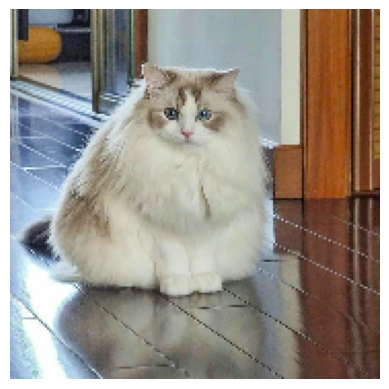

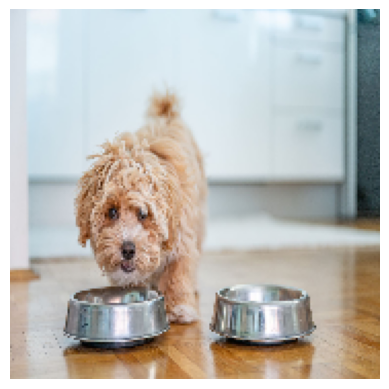

(2, 180, 180, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_1
Received: inputs=['Tensor(shape=(200, 180, 180, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_1
Received: inputs=['Tensor(shape=(2, 180, 180, 3))']
  warnings.warn(msg)


In [8]:
import matplotlib.pyplot as plt

# explain predictions of the model on three images
e = shap.DeepExplainer(test_model, background)

cat_path = keras.utils.get_file(
    fname="cat6.jpg",
    origin="https://www.brightstarbuddies.com.au/blog/wp-content/uploads/sites/8/Bellamy.jpg")

dog_path = keras.utils.get_file(
    fname="dog.jpeg",
    origin="https://hips.hearstapps.com/hmg-prod/images/little-cute-maltipoo-puppy-royalty-free-image-1652926025.jpg"
)

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

cat_tensor = get_img_array(cat_path, target_size=(180, 180))
dog_tensor = get_img_array(dog_path, target_size=(180, 180))

plt.axis("off")
plt.imshow(cat_tensor[0].astype("uint8"))
plt.show()
plt.axis("off")
plt.imshow(dog_tensor[0].astype("uint8"))
plt.show()

test_set = np.stack((cat_tensor,dog_tensor),axis=0)
test_set = test_set[:, 0, :, :, :]
print(test_set.shape)

# For some reason we have an extra dimension to our shap_values output.
# Dropping the extra dimension from the shap_values tensor using np.squeeze()
shap_values = e.shap_values(test_set)

Note that I'm indexing the shap_values tensor to drop an extra (unecessary) dimension that the function is returning.

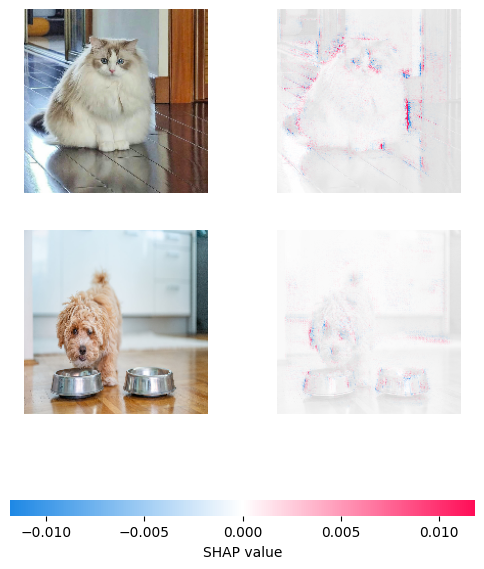

In [9]:
shap.image_plot(shap_values[:,:,:,:,0],pixel_values=test_set.astype('uint8'))